In [15]:
#We use stable diffusion model to inpaint our images
#Importing the required libraries
# import tensorflow as tf

# import os
# import pathlib
# import time
# import datetime
import torch
import numpy as np
import PIL
import pandas as pd

from matplotlib import pyplot as plt
from IPython import display


In [2]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#copy all the images locally to reduce time
# !cp -r /content/drive/MyDrive/Dataset/ /content/Dataset/

In [11]:
# PATH_TO_DATASET = '/content/Dataset/'
PATH_TO_DATASET = '/content/drive/MyDrive/Dataset/'
# PATH_TO_DATASET = '/home/aman/Desktop/Deep-Learning-2023S/Assignment-3/Dataset/'
PATH_TO_TRAIN = PATH_TO_DATASET + 'Training_Data/'
categories = ['Cat', 'Dog', 'Elephant', 'Tiger']
data = []
for category in categories:
    PATH_TO_TRAIN_CATEGORY = PATH_TO_TRAIN + category + '/'
    PATH_TO_MASKED_TRAINING_IMAGES = PATH_TO_TRAIN_CATEGORY + 'Masked_Train/'
    PATH_TO_UNMASKED_TRAINING_IMAGES = PATH_TO_TRAIN_CATEGORY + 'Unmasked_Train/'
    #Get the csv from masked images folder that contains the image names and their corresponding labels
    #First line of the csv file is the header
    masked_csv = pd.read_csv(PATH_TO_MASKED_TRAINING_IMAGES + 'masked_info.csv', header=0)
    print(masked_csv.head())
    #Save the image, mask image of same size, image name and category in a list
    for index, row in masked_csv.iterrows():
        #Load the image
        image = PIL.Image.open(PATH_TO_MASKED_TRAINING_IMAGES + row['filename'])
        image = image.convert('RGB').resize((512, 512))
        #Make a mask image of same size as the image
        mask = PIL.Image.new('RGB', image.size, 0)
        #Get the bounding box of the mask
        box1_row = row['box1_row']*2
        box1_col = row['box1_col']*2
        box2_row = row['box2_row']*2
        box2_col = row['box2_col']*2
        #All the bounding boxes are of size 75x75
        box1 = (box1_col, box1_row, box1_col + 149, box1_row + 149)
        box2 = (box2_col, box2_row, box2_col + 149, box2_row + 149)
        #Draw the bounding boxes on the mask image without using imagedraw
        mask.paste((255, 255, 255), box1)
        mask.paste((255, 255, 255), box2)
        #Save the image, mask image, image name and category in a list
        data.append([image, mask, row['filename'], category])
        #Show the image and mask image side by side
        # plt.figure()
        # plt.subplot(1, 2, 1)
        # plt.imshow(image)
        # plt.subplot(1, 2, 2)
        # plt.imshow(mask)
        # plt.show()
        break




   Unnamed: 0               filename  box1_row  box1_col  box2_row  box2_col
0           0  Cat-Train (1085).jpeg        67         6        41       152
1           1   Cat-Train (900).jpeg        86        23       105       165
2           2  Cat-Train (1759).jpeg        60        99         3       140
3           3   Cat-Train (969).jpeg        14       138        47       137
4           4  Cat-Train (1559).jpeg       106        95        41       158
   Unnamed: 0              filename  box1_row  box1_col  box2_row  box2_col
0           0   Dog-Train (157).jpg       103       159        97        81
1           1   Dog-Train (33).jpeg        77       168        31        16
2           2  Dog-Train (512).jpeg        49        61        39        82
3           3   Dog-Train (174).jpg        55       168        84        22
4           4  Dog-Train (502).jpeg        57       142         8        26
   Unnamed: 0                    filename  box1_row  box1_col  box2_row  \
0      

In [49]:
image, mask_image, filename, category = data[2]

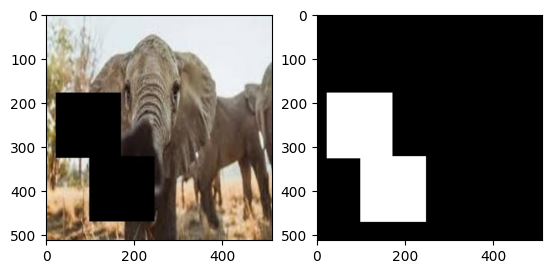

In [50]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask_image)
plt.show()

In [17]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

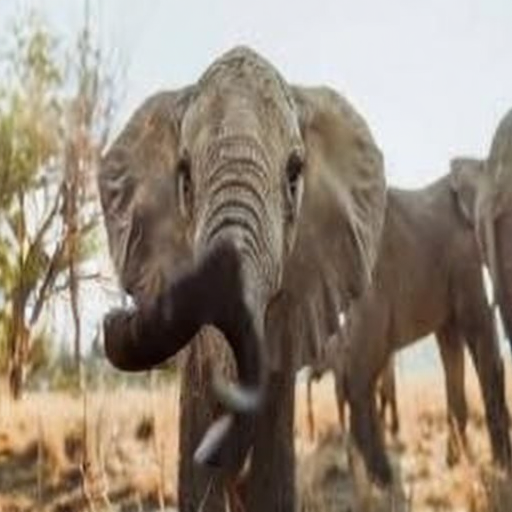

In [54]:
prompt = "Real image of an elephant, no text"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image1 = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
# image1.save("./output_from_model.png")
image1.show()